In [11]:
# Python standard library packages to do file/folder manipulations,
# pickle is a package to store python variables
import glob, os, pickle, sys

# time grabs current clock time and copy to safely make copies of large
# variables in memory.
import time, copy

# datetime package is used to get and manipulate date and time data
from datetime import datetime

# this packages helps load and save .mat files older than v7
import hdf5storage

# numpy works with arrays, pandas used to work with fancy numpy arrays
import numpy as np
import pandas as pd

# matplotlib is used to plot and animate to make movies
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# moviepy helps open the video files in Python
from moviepy.editor import VideoClip, VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage

# Scikit-learn is a go-to library in Python for all things machine learning
from sklearn.decomposition import PCA

# tqdm helps create progress bars in for loops
from tqdm import tqdm

# Scipy is a go-to scientific computing library. We'll use it for median filtering.
from scipy.ndimage import median_filter

# Configuring matplotlib to show animations in a colab notebook as javascript
# objects for easier viewing.
from matplotlib import rc

rc("animation", html="jshtml")

We'll now go through `mmpy` parameters. They are a handful and can be overwhelming, but they are very easy to understand! 

Parameters are cruicial to `mmpy` as they lay out some hard-coded choices we need to make when running this pipeline. I will explain each parameter as we encounter them in the cell below, so please read through this cell below as you run it.


In [ ]:
"""2. Setup run parameters for MotionMapper."""

import motionmapperpy as mmpy

#% Load the default parameters -- we're just updating these for ease of use now.
parameters = mmpy.setRunParameters()
parameters

{'numProcessors': 16,
 'numPeriods': 25,
 'omega0': 5,
 'samplingFreq': 100,
 'minF': 1,
 'maxF': 50,
 'tSNE_method': 'barnes_hut',
 'perplexity': 32,
 'embedding_batchSize': 128000,
 'maxOptimIter': 500,
 'trainingSetSize': 64000,
 'maxNeighbors': 200,
 'kdNeighbors': 5,
 'training_perplexity': 20,
 'training_numPoints': 32000,
 'minTemplateLength': 1,
 'waveletDecomp': True,
 'useGPU': -1,
 'n_neighbors': 15,
 'train_negative_sample_rate': 5,
 'embed_negative_sample_rate': 1,
 'min_dist': 0.1,
 'umap_output_dims': 2,
 'n_training_epochs': 100,
 'rescale_max': 100,
 'method': 'TSNE',
 'projectPath': 'mmpy_lts_1d'}

In [ ]:
# %%%%%%% PARAMETERS TO CHANGE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# These need to be revised everytime you are working with a new dataset. #
import glob
import h5py
import natsort

parameters.projectPath = "mmpy_lts_all_filtered"  #% Full path to the project directory.


parameters.method = "TSNE"  #% We can choose between 'TSNE' or 'UMAP'

parameters.minF = 1  #% Minimum frequency for Morlet Wavelet Transform

parameters.maxF = 50  #% Maximum frequency for Morlet Wavelet Transform,
#% usually equal to the Nyquist frequency for your
#% measurements.

parameters.samplingFreq = 100  #% Sampling frequency (or FPS) of data.

parameters.numPeriods = 25  #% No. of dyadically spaced frequencies to
#% calculate between minF and maxF.
projectionFiles = glob.glob(parameters.projectPath + "/Projections/*pcaModes.mat")
print("Found {} projection files".format(len(projectionFiles)))
print(f"Project path: {parameters.projectPath}")
projectionFiles = natsort.natsorted(projectionFiles)
with h5py.File(projectionFiles[0], "r") as f:
    m = f["projections"][:].T
# parameters.pcaModes = #comps_above_thresh #% Number of low-d features.
parameters.pcaModes = m.shape[1]  #%Number of PCA projections in saved files.
parameters.numProjections = parameters.pcaModes
parameters.numProcessors = -1  #% No. of processor to use when parallel
#% processing for wavelet calculation (if not using GPU)
#% and for re-embedding. -1 to use all cores
#% available.

parameters.useGPU = 0  #% GPU to use for wavelet calculation,
#% set to -1 if GPU not present.

# parameters.training_numPoints = 3000    #% Number of points in mini-trainings.


# %%%%% NO NEED TO CHANGE THESE UNLESS MEMORY ERRORS OCCUR %%%%%%%%%%

# parameters.trainingSetSize = 5000  #% Total number of training set points to find.
#% Increase or decrease based on
#% available RAM. For reference, 36k is a
#% good number with 64GB RAM.

# parameters.embedding_batchSize = 30000  #% Lower this if you get a memory error when
#% re-embedding points on a learned map.

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Found 204 projection files
Project path: mmpy_lts_all_filtered


In [ ]:
import h5py

z_vals_file = "/Genomics/ayroleslab2/scott/git/lts-manuscript/analysis/mmpy_lts_all_filtered/TSNE/20221207_sigma1_8_minregions40_zVals_wShed_groups_finalsave.mat"

with h5py.File(z_vals_file, "r") as f:
    z_val_names_dset = f["zValNames"]
    references = [
        f[z_val_names_dset[dset_idx][0]]
        for dset_idx in range(z_val_names_dset.shape[0])
    ]
    z_val_names = ["".join(chr(i) for i in obj[:]) for obj in references]
    z_lens = [l[0] for l in f["zValLens"][:]]

In [13]:
wshedfile = h5py.File(z_vals_file, "r")
wregs = wshedfile["watershedRegions"][:].flatten()
ethogram = np.zeros((wregs.max() + 1, len(wregs)))

for wreg in range(1, wregs.max() + 1):
    ethogram[wreg, np.where(wregs == wreg)[0]] = 1.0


# ethogram = np.split(ethogram.T, np.cumsum(wshedfile['zValLens'][:].flatten())[:-1])

# fig, axes = plt.subplots(2, 1, figsize=(20,10))

# for e, name, ax in zip(ethogram, wshedfile['zValNames'][0], axes.flatten()):
#   print(e.shape)
#   ax.imshow(e.T, aspect='auto', cmap=mmpy.gencmap())
#   ax.set_title(name[0][0])
#   ax.set_yticks([i for i in range(1, wregs.max()+1, 4)])
#   ax.set_yticklabels(['Region %i'%(j+1) for j in range(1, wregs.max()+1, 4)])

#   xticklocs = [6000*i for i in range(3)]
#   ax.set_xticks(xticklocs)
#   ax.set_xticklabels([j/(6000) for j in xticklocs])

# ax.set_xlabel('Time (min)')

In [14]:
for wreg in range(1, wregs.max() + 1):
    ethogram[wreg, np.where(wregs == wreg)[0]] = 1.0

In [29]:
ethogram_split = np.split(wregs, np.cumsum(wshedfile["zValLens"][:].flatten())[:-1])

In [96]:
# 20220326-lts-cam3_day4_24hourvars-3-pcaModes
example_base_file = h5py.File("20220217-lts-cam3_day4_24hourvars.h5")
example_base_sleap_tracks = example_base_file['tracks'][:].T
tape = 

In [97]:
example_base_sleap_tracks.shape

(8636544, 24)

In [74]:
import utils.trx_utils as trx_utils
import importlib

In [91]:
importlib.reload(trx_utils)

<module 'utils.trx_utils' from '/Genomics/ayroleslab2/scott/git/lts-manuscript/analysis/utils/trx_utils.py'>

In [98]:
%matplotlib inline
trx_utils.plot_trx_no_vid(
    example_base_sleap_tracks[5300:5400, :, :, np.newaxis], fly_ids=[3], frame_end=20
)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

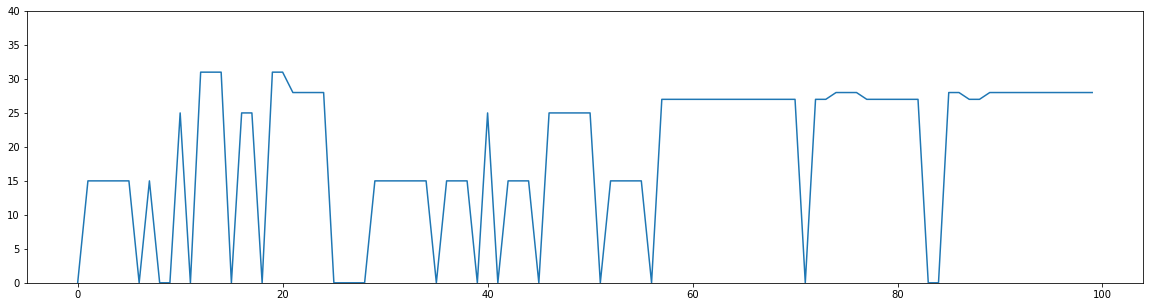

In [89]:
%matplotlib inline
plt.figure(figsize=(20, 5))
plt.ylim(0, 40)
plt.plot(ethogram_split[0][5200:5300])
plt.show()

In [99]:
example_file = "/Genomics/ayroleslab2/scott/long-timescale-behavior/data/organized_tracks/20220217-lts-cam1/cam1_20220217_0through190_cam1_20220217_0through190_100-tracked.analysis.h5"
with h5py.File(example_file, "r") as f:
    node_names = [n.decode() for n in f["node_names"][:]]

In [100]:
with h5py.File("20220217-lts-cam3_day4_24hourvars.h5", "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    locations = trx_utils.fill_missing(locations, kind="linear")
    locations = trx_utils.smooth_median(locations)
    # We want the proboscis to capture the deviation from the head -- so here we replace nans
    head_prob_interp = np.where(
        np.isnan(locations[:, node_names.index("proboscis"), :, :]),
        locations[:, node_names.index("head"), :, :],
        locations[:, node_names.index("proboscis"), :, :],
    )
    locations[:, node_names.index("proboscis"), :, :] = head_prob_interp

    instance_count = 4
    for i in range(instance_count):
        data = locations[:, :, :, i]

        data = trx_utils.normalize_to_egocentric(
            x=data,
            ctr_ind=node_names.index("thorax"),
            fwd_ind=node_names.index("head"),
        )
        data = np.delete(
            data,
            [
                node_names.index("thorax"),
                node_names.index("head"),
            ],
            axis=1,
        )

        # logger.info("Shape before masking: %s", data.shape)
        # mask = np.all(np.isnan(data[:, :, 0]) | np.equal(data[:, :, 0], 0), axis=1)
        # with h5py.File(
        #     f"{projectPath}/Projections/{Path(Path(filename).stem).stem}-{i}-missing-data-indices.h5",
        #     "w",
        # ) as f:
        #     dset = f.create_dataset("missing_data_indices", data=mask, compression="lzf")
        data = trx_utils.fill_missing(data)
        # data = data[~mask, :, :]
        # logger.info("Shape after masking: %s", data.shape)
        if data.shape[0] == 0:
            continue
        data[~np.isfinite(data)] = 1e-12
        data[data == 0] = 1e-12

IndentationError: unexpected indent (4198107633.py, line 39)

In [31]:
ethogram_split[2].shape

(8636544,)

In [20]:
ethogram_indiv = np.split(
    ethogram.T, np.cumsum(wshedfile["zValLens"][:].flatten())[:-1]
)

In [23]:
ethogram.shape

(40, 1761755735)

Above covers usually relevant parameters when using `mmpy`. However, there are parameters associated with tSNE and UMAP implementations, such as below, which aren't usually required to be changed.

In [ ]:
# # %%%%%%% tSNE parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# #% can be 'barnes_hut' or 'exact'. We'll use barnes_hut for this tutorial for speed.
# parameters.tSNE_method = 'barnes_hut'

# # %2^H (H is the transition entropy)
# parameters.perplexity = 32

# # %number of neigbors to use when re-embedding
# parameters.maxNeighbors = 200

# # %local neighborhood definition in training set creation
# parameters.kdNeighbors = 5

# # %t-SNE training set perplexity
# parameters.training_perplexity = 20


# # %%%%%%%% UMAP Parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# # Size of local neighborhood for UMAP.
# n_neighbors = 15

# # Negative sample rate while training.
# train_negative_sample_rate = 5

# # Negative sample rate while embedding new data.
# embed_negative_sample_rate = 1

# # Minimum distance between neighbors.
# min_dist = 0.1

## 3.1&nbsp; Visualizing wavelet amplitudes

This section is not required to be run by motionmapperpy, but we'll go through it to visualize spectrograms on one of the low-dimensional time series.

We'll use `mmpy.findWavelets` function to obtain the waveletes, and plot the obtained spectrogram for each feature/projection. 

In [ ]:
import pathlib
import h5py
import natsort

# wlets, freqs = mmpy.findWavelets(projs_list[0], projs_list[0].shape[1], parameters.omega0, parameters.numPeriods, parameters.samplingFreq, parameters.maxF, parameters.minF, parameters.numProcessors, parameters.useGPU)
projectionFiles = glob.glob(parameters.projectPath + "/Projections/*pcaModes.mat")
projectionFiles = natsort.natsorted(projectionFiles)
projectionFile = projectionFiles[0]
wavelet_path = f"{parameters.projectPath}/Wavelets/{pathlib.Path(projectionFile).stem}-wavelets.mat"
with h5py.File(wavelet_path, "r") as hfile:
    wlets = hfile["wavelets"][1 : 60 * 100].T
    freqs = hfile["f"]

In [ ]:
import sleap

In [ ]:
skeleton = sleap.skeleton.Skeleton.load_json("../data/skeleton.json")

In [ ]:
example_file = "/Genomics/ayroleslab2/scott/long-timescale-behavior/data/organized_tracks/20220217-lts-cam1/cam1_20220217_0through190_cam1_20220217_0through190_100-tracked.analysis.h5"
with h5py.File(example_file, "r") as f:
    node_names = [n.decode() for n in f["node_names"][:]]

node_names = [n for n in node_names if n not in ["thorax", "head"]]
node_names = np.repeat(node_names, 2)
list(node_names)

['eyeL',
 'eyeL',
 'eyeR',
 'eyeR',
 'abdomen',
 'abdomen',
 'forelegL',
 'forelegL',
 'forelegR',
 'forelegR',
 'midlegL',
 'midlegL',
 'midlegR',
 'midlegR',
 'hindlegL',
 'hindlegL',
 'hindlegR',
 'hindlegR',
 'wingL',
 'wingL',
 'wingR',
 'wingR',
 'proboscis',
 'proboscis']

In [ ]:
nodes = [n.name for n in skeleton.nodes if n.name not in ["thorax", "head"]]
nodes = np.repeat(nodes, 2)
nodes = list(nodes)

In [ ]:
node_num = 1
start_frame = 1000
end_frame = 2000
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.imshow(
    wlets[25 * node_num : 25 * (node_num + 1), start_frame:end_frame],
    cmap="PuRd",
    origin="lower",
)
ax.set_yticks([0, 5, 10, 15, 20, 24])
ax.set_yticklabels(["%0.1f" % freqs[j] for j in [0, 5, 10, 15, 20, 24]])
plt.savefig(
    f"{parameters.projectPath}/figures/wavelet_example.png",
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
fig, axes = plt.subplots(24, 1)
# fig.set_figheight(6)
# fig.set_figwidth(8)
axes[0].set_title(
    f"Wavelet Transform of Projections from Frame {start_frame} to {end_frame}"
)
for node_num, ax in enumerate(axes.flatten()):
    ax.imshow(
        wlets[25 * node_num : 25 * (node_num + 1), start_frame:end_frame],
        cmap="PuRd",
        origin="lower",
    )
    # ax.set_yticks([0, 5, 10, 15, 20, 24])
    ax.set_yticks([])
    ax.set_yticklabels([])
    # ax.set_yticklabels(['%0.1f'%freqs[j] for j in [0, 5, 10, 15, 20, 24]])
    # ax.get_yaxis().set_visible(False)
    # if node_num == 11:
    # ax.get_yaxis().set_visible(True)
    ax.set_ylabel(
        nodes[node_num], rotation=0, fontsize=8, ma="left", ha="right", va="center"
    )
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.spines.left.set_visible(False)
    if node_num != 23:
        ax.set_xticklabels([])
        ax.set_xticks([])

ax.set_xlabel("Relative Frame Number")
fig.subplots_adjust(hspace=-0.8)
plt.tight_layout()

plt.savefig(
    f"{parameters.projectPath}/figures/wavelet_example_by_part.png",
    dpi=600,
    bbox_inches="tight",
)
plt.close()

As we can see, our low-d time series is soon dwarfed by the 25-dimensional wavelet amplitudes obtained for each low-d feature! This is why its wise to spend some time reducing the dimensionality of our original data, as much as we can. 


# 5.&nbsp; Creating a training set and embedding it using tSNE/UMAP 

Even though we are working with toy datasets, we have two extremely high dimensional timeseries we're using to create a smaller and more interpretable representation. tSNE and UMAP both need to compute all-to-all distances in high-dimensional space to find neighboring points and embed them closely on this low-dimensional space we're building. This computation can quickly exhaust memory (RAM) and scale exponentially with datapoints. 

To navigate this challenge, we do a subsampling procedure to create a training set, and use tSNE or UMAP to create training embeddings. All of this is done in the cell below.

**Time taken** : TSNE 86 sec | UMAP 44 sec


In [ ]:
import glob
import natsort
import h5py

projectionFiles = glob.glob(parameters.projectPath + "/Projections/*pcaModes.mat")
projectionFiles = natsort.natsorted(projectionFiles)
print(projectionFiles[0])
with h5py.File(projectionFiles[0], "r") as f:
    m = f["projections"][:].T

# %%%%%
print(m.shape)
parameters.pcaModes = m.shape[1]  #%Number of PCA projections in saved files.
parameters.numProjections = parameters.pcaModes
# %%%%%
del m

print(datetime.now().strftime("%m-%d-%Y_%H-%M"))
print("tsneStarted")

if parameters.method == "TSNE":
    if parameters.waveletDecomp:
        tsnefolder = parameters.projectPath + "/TSNE/"
    else:
        tsnefolder = parameters.projectPath + "/TSNE_Projections/"
elif parameters.method == "UMAP":
    tsnefolder = parameters.projectPath + "/UMAP/"
for i in range(len(projectionFiles)):
    if not os.path.exists(tsnefolder + "training_tsne_embedding.mat"):
        print("Calculating wavelets...")
        mmpy.get_wavelets(projectionFiles, parameters, i)
        print(datetime.now().strftime("%m-%d-%Y_%H-%M"))

In [ ]:
# t1 = time.time()

# mmpy.subsampled_tsne_from_projections(parameters, parameters.projectPath)

# print('Done in %i seconds.'%(time.time()-t1))

Note that the `training set` and `training embedding` are both save in the `project_directory/TSNE` or `project_directory/UMAP` directories depending on which method you're using. We'll load the training embedding below and plot it. You can play around with the sigma value here to change the coarseness of the density map. 

In [ ]:
trainy = hdf5storage.loadmat(
    "%s/%s/training_embedding.mat" % (parameters.projectPath, parameters.method)
)["trainingEmbedding"]
m = np.abs(trainy).max()


sigma = 2.5
_, xx, density = mmpy.findPointDensity(trainy, sigma, 511, [-m - 20, m + 20])


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(
    trainy[:, 0], trainy[:, 1], marker=".", c=np.arange(trainy.shape[0]), s=1
)
axes[0].set_xlim([-m - 20, m + 20])
axes[0].set_ylim([-m - 20, m + 20])

axes[1].imshow(
    density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin="lower"
)
from datetime import datetime

date = datetime.now().strftime("%Y%m%d")
plt.savefig(
    f"{parameters.projectPath}/figures/{date}-sigma{sigma}-embedding-density.png",
    dpi=600,
)

In [ ]:
projectionFiles = glob.glob(parameters.projectPath + "/Projections/*pcaModes.mat")
projectionFiles = natsort.natsorted(projectionFiles)
m = h5py.File(projectionFiles[0], "r")["projections"]
# %%%%%
parameters.pcaModes = m.shape[1]  #%Number of PCA projections in saved files.
parameters.numProjections = parameters.pcaModes
# %%%%%
del m

mmpy.findWatershedRegions(
    parameters,
    minimum_regions=20,
    startsigma=1,
    pThreshold=[0.33, 0.67],
    saveplot=True,
    endident="*-pcaModes.mat",
)

Processing mmpy_lts_1d/Projections/20220217-lts-cam2_day1_24hourvars-2-pcaModes.mat
1/48 Loading embedding for 20220217-lts-cam2_day1_24hourvars-2-pcaModes 0.00 seconds.
shape of zVals: (8636544, 2)
[[ 15.49551512 -26.27576161]
 [ 15.43283051 -26.26500904]
 [ 15.2593209  -26.08624862]
 [ 15.17292775 -25.80989585]
 [ 14.32329055 -23.7264253 ]]
Processing mmpy_lts_1d/Projections/20220418-lts-cam2_day1_24hourvars-1-pcaModes.mat
2/48 Loading embedding for 20220418-lts-cam2_day1_24hourvars-1-pcaModes 4.08 seconds.
shape of zVals: (8636544, 2)
[[ 16.59999824 -26.97678653]
 [ 16.62040528 -26.95802907]
 [ 16.61201464 -26.98000321]
 [ 16.36675808 -26.81556007]
 [ 14.18094211 -23.74289876]]
Processing mmpy_lts_1d/Projections/20220312-lts-cam4_day1_24hourvars-0-pcaModes.mat
3/48 Loading embedding for 20220312-lts-cam4_day1_24hourvars-0-pcaModes 7.93 seconds.
shape of zVals: (8636544, 2)
[[ 15.49938609 -26.66350342]
 [ 15.3140919  -26.40035275]
 [ 15.08047692 -25.95797958]
 [ 14.91764376 -25.58861

On the left, we see a scatter plot and on the right, we see a Gaussian kernel convolved density estimation of these points. Does it surprise you? What does changing the sigma value do?  


# 6.&nbsp; Finding embeddings for all data

Now, we can find embeddings for our entire dataset! We'll use the `mmpy.findEmbeddings` function which requires the training set and the 2-d embeddings we find in the last step, and the high-d 'projections' time series for each dataset. We'll save the obtained embeddings for each dataset neatly in the Projections folder so that we can reference them later.

**Running time** : TSNE 19 mins | UMAP 3 mins

In [ ]:
files = glob.glob(parameters.projectPath + "/Projections/*_%s.mat" % ("zVals"))
ally = hdf5storage.loadmat(files[0])["zValues"]

NameError: name 'parameters' is not defined

We can visualize the obtained embeddings by calling the cell below.

In [ ]:
# load all the embeddings
# for i in glob.glob(parameters.projectPath+'/Projections/*zVals.mat'):
# ally = hdf5storage.loadmat(i)['zValues']

m = np.abs(ally).max()

sigma = 2.0
_, xx, density = mmpy.findPointDensity(ally, sigma, 511, [-m - 10, m + 10])


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(ally[:, 0], ally[:, 1], marker=".", c=np.arange(ally.shape[0]), s=1)
axes[0].set_xlim([-m - 20, m + 20])
axes[0].set_ylim([-m - 20, m + 20])

axes[1].imshow(
    density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin="lower"
)
plt.savefig("tmp4.png", dpi=300)

# 7.&nbsp; Watershed transform on the density map. 

There is another handy function in `motionmapperpy` called `findWatershedRegions`. This will do an iterative watershed transform on the behavioral density map until the given `minimum_regions` are found in the density map.

It saves watershed transformed output of the embedding in `project_director/UMAP/zVals_wShed_groups.mat` file.


In [ ]:
# import matplotlib.pyplot as plt
# startsigma = 4.2 if parameters.method == 'TSNE' else 1.0
# mmpy.findWatershedRegions(parameters, minimum_regions=10, startsigma=startsigma, pThreshold=[0.33, 0.67],
#                      saveplot=True, endident = '*_pcaModes.mat')
mmpy.findWatershedRegions(
    parameters,
    minimum_regions=20,
    startsigma=1,
    pThreshold=[0.33, 0.67],
    saveplot=True,
    endident="*-pcaModes.mat",
)
# from IPython.display import Image
# Image(glob.glob('%s/%s/zWshed*.png'%(parameters.projectPath, parameters.method))[0])

# 8.&nbsp; Ethograms and videos

We can now create ethograms using the watershed region time series created in the last step. 

In [ ]:
wshedfile = hdf5storage.loadmat(
    "%s/%s/zVals_wShed_groups.mat" % (parameters.projectPath, parameters.method)
)

wregs = wshedfile["watershedRegions"].flatten()
ethogram = np.zeros((wregs.max() + 1, len(wregs)))

for wreg in range(1, wregs.max() + 1):
    ethogram[wreg, np.where(wregs == wreg)[0]] = 1.0

RuntimeError: Unable to get group info (addr overflow, addr = 1936, size = 328, eoa = 1312)

In [ ]:
ethogram_2 = np.split(ethogram.T, np.cumsum(wshedfile["zValLens"][0].flatten())[:-1])

In [ ]:
[ethogram.shape for ethogram in ethogram]
wshedfile["zValNames"][0]

In [ ]:
[e[0:1000, :].shape for e in ethogram_2[0:4]]

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(20, 10))
ethogram_subset = [e[0:1000, :] for e in ethogram_2[0:4]]

for e, name, ax in zip(ethogram_subset, wshedfile["zValNames"][0], axes.flatten()):
    print(e.shape)
    ax.imshow(e.T, aspect="auto", cmap=mmpy.gencmap())
    ax.set_title(name[0][0])
    ax.set_yticks([i for i in range(1, wregs.max() + 1, 4)])
    ax.set_yticklabels(["Region %i" % (j + 1) for j in range(1, wregs.max() + 1, 4)])


ax.set_xlabel("Time (min)")
plt.savefig("tmp5.png", dpi=300)

In [ ]:
wshedfile = hdf5storage.loadmat(
    "%s/%s/zVals_wShed_groups.mat" % (parameters.projectPath, parameters.method)
)

try:
    tqdm._instances.clear()
except:
    pass

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
zValues = wshedfile["zValues"]
m = np.abs(zValues).max()

sigma = 1.0
_, xx, density = mmpy.findPointDensity(zValues, sigma, 1028, [-m - 10, m + 10])
axes[0].imshow(
    density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin="lower"
)
axes[0].axis("off")
axes[0].set_title("Method : %s" % parameters.method)
sc = axes[0].scatter([], [], marker="o", color="k", s=500)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
zValues = wshedfile["zValues"]
m = np.abs(zValues).max()

In [ ]:
sigma = 1.0
_, xx, density = mmpy.findPointDensity(zValues, sigma, 511, [-m - 10, m + 10])

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.imshow(
    density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin="lower"
)
axes.axis("off")
axes.set_title("Method : %s" % parameters.method)
sc = axes.scatter([], [], marker="o", color="k", s=500)


def animate(t):
    #   t = int(t*clips[h5ind].fps)+tstart
    #   axes[1].clear()
    #   im = axes[1].imshow(clips[h5ind].get_frame(t/clips[h5ind].fps), cmap='Greys', origin='lower')
    #   for conn in connections:
    #       axes[1].plot(h5s[h5ind][t, conn, 0], h5s[h5ind][t, conn, 1], 'k-')
    #   axes[1].axis('off')
    sc.set_offsets(zValues[int(t)])
    return mplfig_to_npimage(fig)  # im, ax

In [ ]:
anim = VideoClip(animate, duration=100)  # will throw memory error for more than 100.
plt.close()
anim.ipython_display(fps=100, loop=True, autoplay=True, maxduration=120)

## 8.1 Visualize behavioral map

Run the below code to see the behavioral map in action. 

This may take **2 minutes** to run. 

In [ ]:
wshedfile = hdf5storage.loadmat(
    "%s/%s/zVals_wShed_groups.mat" % (parameters.projectPath, parameters.method)
)

try:
    tqdm._instances.clear()
except:
    pass

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
zValues = wshedfile["zValues"]
m = np.abs(zValues).max()


sigma = 1.0
_, xx, density = mmpy.findPointDensity(zValues, sigma, 511, [-m - 10, m + 10])
axes.imshow(
    density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin="lower"
)
axes.axis("off")
axes.set_title("Method : %s" % parameters.method)
sc = axes.scatter([], [], marker="o", color="k", s=500)

h5ind = 0
tstart = 0
# connections = [np.arange(6,10), np.arange(10,14), np.arange(14,18), np.arange(18,22), np.arange(22,26), np.arange(26,30),
#               [2,0,1],[0,3,4,5], [31,3,30]]


def animate(t):
    # t = int(t*clips[h5ind].fps)+tstart
    # axes[1].clear()
    # im = axes[1].imshow(clips[h5ind].get_frame(t/clips[h5ind].fps), cmap='Greys', origin='lower')
    # for conn in connections:
    #     axes[1].plot(h5s[h5ind][t, conn, 0], h5s[h5ind][t, conn, 1], 'k-')
    # axes[1].axis('off')
    sc.set_offsets(zValues[t])
    return mplfig_to_npimage(fig)  # im, ax


anim = VideoClip(animate, duration=2)  # will throw memory error for more than 100.
plt.close()
anim.ipython_display(fps=15, loop=True, autoplay=True, maxduration=120)

At this point, you know everything you need to know to create a behavioral map for a set of datasets. But this is where we can actually start doing some science! 

Open the project directory on the left pane. We should see some files in *Fly_Leap_mmpy/TSNE* or Fly_Leap_mmpy/UMAP folder. The 2-dimensional embeddings of all the files we've used for this project can be found in the **zVals_wShed_groups.mat** file which can be opened using hdf5storage in Python (as we did in the previous cell) or natively in MATLAB. This is where we can start doing some science!


In [ ]:
plt.figure()
plt.imshow(wshedfile["density"])

In [ ]:
wshedfile["zValNames"]

In [ ]:
wshedfile["zValLens"]

In [ ]:
wshedfile["watershedRegions"].shape

In [ ]:
wshedfile["zValues"].shape

In [ ]:
list(wshedfile.keys())

## 8.2 Create region videos



Now we'll try to create region videos - we'll pick contiguous time points that belong in one watershed region, and see what the animals is doing at those times by creating a movie.  

In [ ]:
def makeGroupsAndSegments(watershedRegions, zValLens, min_length=10, max_length=100):

    inds = np.zeros_like(watershedRegions)
    start = 0
    for l in zValLens:
        inds[start : start + l] = np.arange(l)
        start += l
    vinds = np.digitize(
        np.arange(watershedRegions.shape[0]),
        bins=np.concatenate([[0], np.cumsum(zValLens)]),
    )

    splitinds = np.where(np.diff(watershedRegions, axis=0) != 0)[0] + 1
    inds = [
        i
        for i in np.split(inds, splitinds)
        if len(i) > min_length and len(i) < max_length
    ]
    wregs = [
        i[0]
        for i in np.split(watershedRegions, splitinds)
        if len(i) > min_length and len(i) < max_length
    ]

    vinds = [
        i
        for i in np.split(vinds, splitinds)
        if len(i) > min_length and len(i) < max_length
    ]
    groups = [np.empty((0, 3), dtype=int)] * watershedRegions.max()

    for wreg, tind, vind in zip(wregs, inds, vinds):
        if np.all(vind == vind[0]):
            groups[wreg - 1] = np.concatenate(
                [
                    groups[wreg - 1],
                    np.array([vind[0], tind[0] + 1, tind[-1] + 1])[None, :],
                ]
            )
    groups = np.array([[g] for g in groups])
    return groups


def makeregionvideo(region, parameters, wshedfile):

    animfps = 50.0
    subs = 2
    submaxframes = 500

    groups = makeGroupsAndSegments(
        wshedfile["watershedRegions"][0], wshedfile["zValLens"][0]
    )
    nregs = len(groups)

    region = region - 1

    outputdir = "%s/%s/region_videos_%i/" % (
        parameters.projectPath,
        parameters.method,
        nregs,
    )
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    groups = groups - 1
    print("[Region %i] Starting" % (region + 1))

    if os.path.isfile(outputdir + "regions_" + "%.3i" % (region + 1) + ".mp4"):
        print("[Region %i] Already present. " % (region + 1))
        return

    tqdm._instances.clear()

    if not groups[region][0].shape[0] or groups[region][0].shape[0] == 1:
        print("[Region %i] No frames in groups." % (region + 1))
        return

    nframes = np.atleast_1d(np.diff(groups[region][0][:, 1:], axis=1).squeeze())
    if np.sum(nframes < submaxframes) == 0:
        print(
            "[Region %i] All frames sequences more than length %i."
            % (region + 1, submaxframes)
        )
        return

    nplots = min(subs * subs, np.sum(nframes < submaxframes))
    longinds = np.where(nframes < submaxframes)[0]
    selectedclips = longinds[np.argsort(nframes[longinds])[::-1]][:nplots]

    vidindslist = groups[region][0][selectedclips, 0]
    framestoplot = np.array(
        [
            np.arange(groups[region][0][i, 1], groups[region][0][i, 2])
            for i in selectedclips
        ]
    )
    maxsize = max([i.shape[0] for i in framestoplot])

    print("[Region %i] Making region video..." % (region + 1))

    subx = max(2, int(np.ceil(np.sqrt(nplots))))
    fig, axes = plt.subplots(subx, subx, figsize=(12, 12))
    fig.subplots_adjust(0, 0, 1.0, 1.0, 0.0, 0.0)

    def make_frame(t):
        j_ = int(t * animfps)
        for i in range(subx * subx):

            ax = axes[i // subx, i % subx]
            ax.clear()
            ax.axis("off")
            if i >= nplots:
                continue
            j = j_ % len(framestoplot[i])
            clip = clips[vidindslist[i]]
            ax.imshow(
                clip.get_frame(framestoplot[i][j] / clip.fps),
                cmap="Greys_r",
                origin="lower",
            )
        return mplfig_to_npimage(fig)

    try:
        tqdm._instances.clear()
    except:
        pass

    t1 = time.time()
    animation = VideoClip(make_frame, duration=maxsize / animfps)

    animation.write_videofile(
        outputdir + "regions_" + "%.3i" % (region + 1) + ".mp4",
        fps=animfps,
        audio=False,
        threads=1,
    )

    print(
        "[Region %i] %i seconds, Saved at %s"
        % (
            region + 1,
            time.time() - t1,
            outputdir + "regions_" + "%.3i" % (region + 1) + ".mp4",
        )
    )

In [ ]:
makeregionvideo(10, parameters, wshedfile)

In [ ]:
# This creates region videos for all the region. This can take a while to run so be careful!
wmax = wshedfile["watershedRegions"].max()
print(wmax)
for i in range(1, wmax + 1):
    makeregionvideo(i, parameters, wshedfile)

In [ ]:
# Set region below to see your video.
region = 10

print("Region %i" % region)
from IPython.display import HTML
from base64 import b64encode

outputdir = "%s/%s/region_vidoes_%i/" % (
    parameters.projectPath,
    parameters.method,
    wshedfile["watershedRegions"].max(),
)
mp4 = open(outputdir + "regions_" + "%.3i" % (region) + ".mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(
    """
<video width=400 controls loop autoplay>
      <source src="%s" type="video/mp4">
</video>
"""
    % data_url
)



You can also zip your project folder by calling 
```!zip -r Fly_Leap_mmpy.zip Fly_Leap_mmpy``` 
and download the folder on your local computer to play around with it. 

In [ ]:
# !zip -r Fly_Leap_mmpy.zip Fly_Leap_mmpy

# Transition Matrix

In [ ]:
wregs = wshedfile["watershedRegions"][0]
wregs = np.split(wregs, np.cumsum(wshedfile["zValLens"][0])[:-1])
transitions = [mmpy.demoutils.getTransitions(w[w > 0]) for w in wregs]

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

statevals = np.arange(1, wshedfile["watershedRegions"].max() + 2)
for ax, d in zip(axes.flatten(), [1, 10, 100, 1000]):
    F = mmpy.demoutils.makeTransitionMatrix(np.concatenate(transitions), d)
    ax.imshow(
        F,
        cmap="PuRd",
        extent=(statevals[0], statevals[-1], statevals[0], statevals[-1]),
    )
    ax.set_xlabel("Initial State")
    ax.set_ylabel("Final State")
plt.savefig("transition_matrix.png", dpi=300)

In [ ]:
_ = mmpy.demoutils.plotLaggedEigenvalues(transitions)
plt.savefig("eigenvalues.png", dpi=300)